# Finding reliable matches cross-check and ratio test

In this recipe, you will learn how filter keypoint matches using cross-check and ratio tests. These techniques are useful for filtering bad matches and improving the overall quality of established correspondences.

In this recipe, we implement two heuristics for filtering bad matches. The first one is the ratio test. It checks whether thebest matche is significantly better than the second best one. The check is performed through comparing matching scores. Two best matches for each keypoint are found using the `knnMatch` method of the `cv2.BFMatcher` class.

The second heuristic is the cross-check test. For two images, $A$ and $B$, it checks whether the matches found in $B$ for keypoints in $A$ are the same as the ones found in $A$ for keypoints in $B$. The correspondences that were found in both directions are retained, and the other ones are removed.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


[[ 0.96592583 -0.25881905  0.        ]
 [ 0.25881905  0.96592583  0.        ]
 [ 0.          0.          1.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
------  data/Lena.png------------    Shape(512, 512, 3) image_orig: uint8
[[120  71 130] [ 97  43 121] [ 93  42 118] [106  64 151] [125 100 181] [120  75 160] [117  65 145] ]
[[ 86  35 108] [ 92  39 114] [119  65 140] [115  70 149] [127  84 159] [115  68 145] [107  56 134] ]
[[ 92  40 110] [106  57 129] [137  81 154] [122  80 151] [136  88 151] [121  73 137] [ 86  35 110] ]
[[105  52 124] [140  87 152] [147 101 163] [127  78 148] [137  81 144] [ 95  43 114] [ 83  31 105] ]
[[139  86 153] [154 113 169] [147 104 167] [129  81 147] [101  53 125] [ 93  37 106] [113  63 122] ]


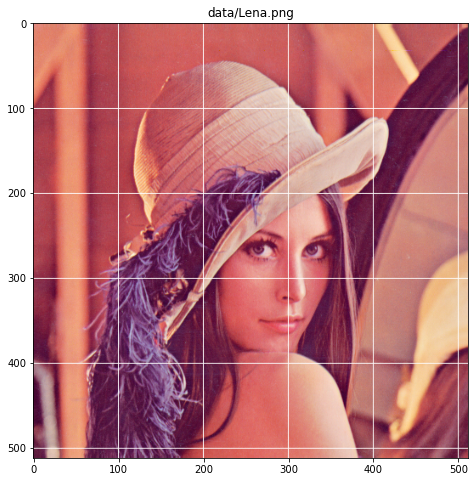

In [2]:
image_orig = cv2.imread('../data/Lena.png')

M = np.array([[math.cos(np.pi/12), -math.sin(np.pi/12), 0],
             [math.sin(np.pi/12), math.cos(np.pi/12), 0],
             [0,0,1]])
Moff = np.eye(3)




##########################################################
print(M)
print(Moff)
print_image('data/Lena.png','image_orig',image_orig,300,305,100,107)
plt_view_image(plt,[["data/Lena.png", 
                     draw_grid(np.copy(image_orig),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

In [3]:
print(Moff)
Moff[0,2] = -image_orig.shape[1]/2
Moff[1,2] = -image_orig.shape[0]/2



##########################################################
print(Moff)
print(np.linalg.inv(Moff)@M@Moff)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[   1.    0. -256.]
 [   0.    1. -256.]
 [   0.    0.    1.]]
[[  0.96592583  -0.25881905  74.98066402]
 [  0.25881905   0.96592583 -57.53468708]
 [  0.           0.           1.        ]]


------  data/scenetext01.jpg-----    Shape(512, 512, 3) img_orig: uint8
[[120  71 130] [ 97  43 121] [ 93  42 118] [106  64 151] [125 100 181] [120  75 160] [117  65 145] ]
[[ 86  35 108] [ 92  39 114] [119  65 140] [115  70 149] [127  84 159] [115  68 145] [107  56 134] ]
[[ 92  40 110] [106  57 129] [137  81 154] [122  80 151] [136  88 151] [121  73 137] [ 86  35 110] ]
[[105  52 124] [140  87 152] [147 101 163] [127  78 148] [137  81 144] [ 95  43 114] [ 83  31 105] ]
[[139  86 153] [154 113 169] [147 104 167] [129  81 147] [101  53 125] [ 93  37 106] [113  63 122] ]
------  image_rotated------------    Shape(512, 512, 3) image_rotated: uint8
[[103  45 117] [ 89  36 104] [ 95  42 106] [117  57 119] [117  58 117] [109  50 112] [106  48 113] ]
[[110  54 122] [ 90  39 104] [ 88  41 102] [109  52 113] [119  57 120] [101  45 111] [109  48 113] ]
[[117  65 126] [ 94  45 111] [ 86  42 105] [101  45 106] [110  52 116] [ 95  42 110] [113  49 115] ]
[[110  63 125] [ 98  51 117] [ 93  45 107] 

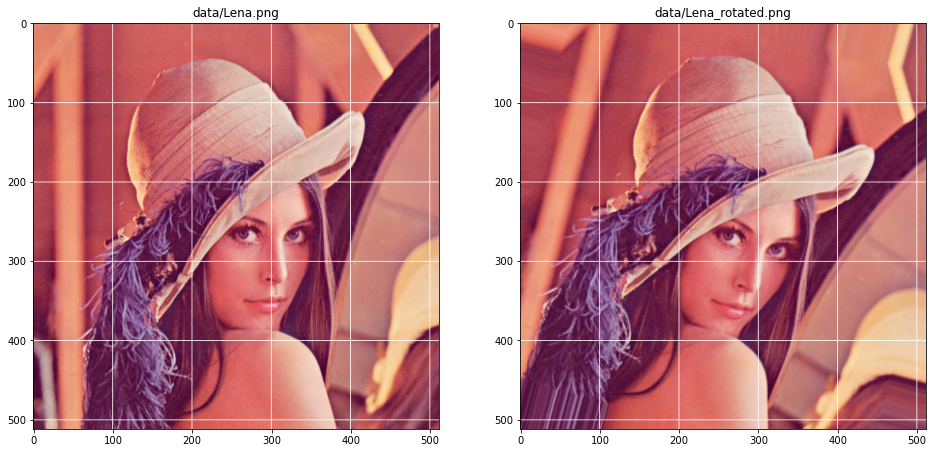

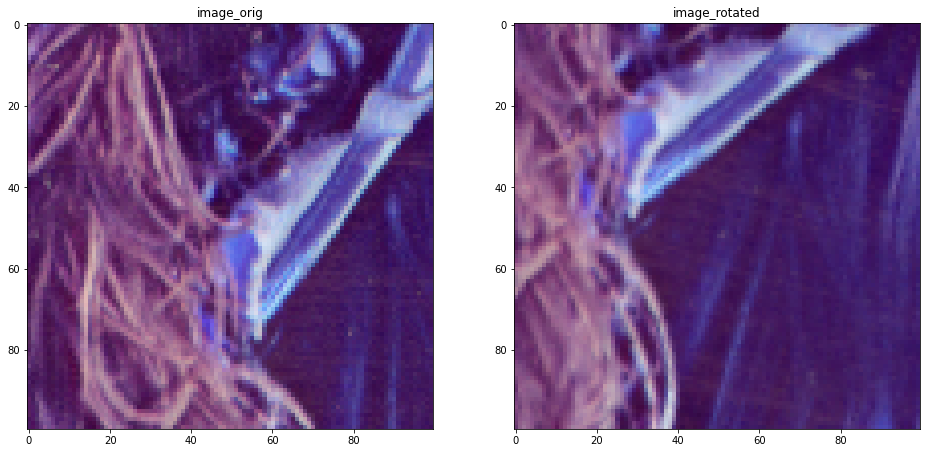

In [4]:
image_rotated = cv2.warpPerspective(image_orig, np.linalg.inv(Moff)@M@Moff,
                    (image_orig.shape[1], image_orig.shape[0]), borderMode=cv2.BORDER_REPLICATE)
cv2.imwrite('../data/Lena_rotated.png', image_rotated)




######################################
print_image('data/Lena.png','img_orig',image_orig,300,305,100,107)
print_image('image_rotated','image_rotated',image_rotated,300,305,100,107)
plt_view_image(plt,[["data/Lena.png", draw_grid(np.copy(image_orig),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/Lena_rotated.png",
                     draw_grid(np.copy(image_rotated),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

plt_view_image(plt,[["image_orig", image_orig[300:400,100:200]],
                    ["image_rotated", image_rotated[300:400,100:200]]],
               figsize=(16,8), axis='on', cmap='gray')

------  data/Lena.png------------    Shape(512, 512) image_grey: uint8
[ 99 82 80 103 133 114 103 82 80 82 98 112 122 110 84 66 59 56 64 68 93 85 106 156 133 98 93 ]
[ 72 76 101 106 117 103 93 78 82 105 118 130 111 76 61 61 61 64 66 66 68 61 92 139 144 114 98 ]
[ 74 92 115 112 117 102 72 78 99 118 134 111 82 66 64 64 72 66 74 61 64 61 76 116 144 126 99 ]
[ 87 117 128 110 111 78 68 99 130 126 98 68 68 64 66 78 84 64 87 64 59 61 72 98 138 128 112 ]
[ 117 138 131 111 87 74 92 133 137 93 68 61 64 64 68 107 84 70 90 82 70 64 82 116 143 132 120 ]
------  image_rotd---------------    Shape(512, 512) image_rotd: uint8
[ 73 62 67 82 82 75 74 80 106 112 99 111 106 79 80 122 150 110 95 131 145 129 115 73 48 41 49 ]
[ 80 64 64 76 82 71 74 87 99 110 105 96 91 84 78 101 134 110 98 131 142 126 118 83 62 49 50 ]
[ 89 70 65 69 77 68 76 87 82 118 110 82 75 83 76 94 127 110 102 134 139 125 114 91 71 63 64 ]
[ 86 76 69 63 75 72 69 70 89 121 105 56 66 78 82 89 131 119 98 141 144 125 117 93 71 68 74 ]
[ 86 

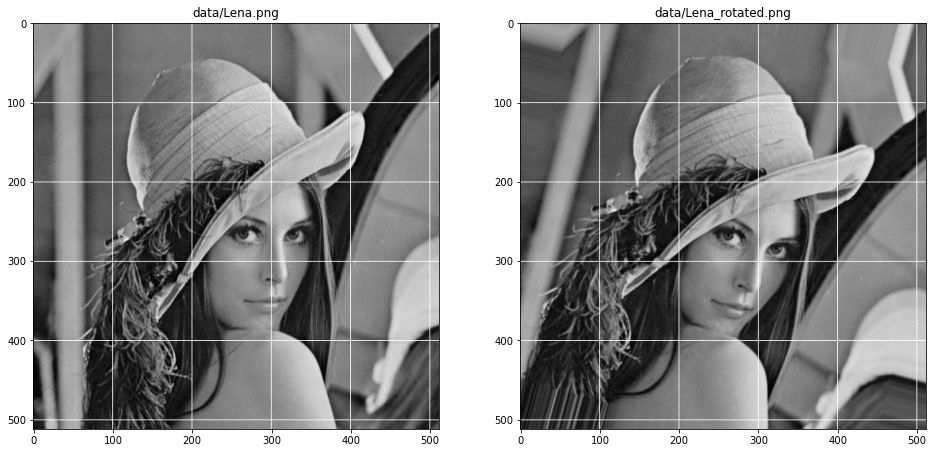

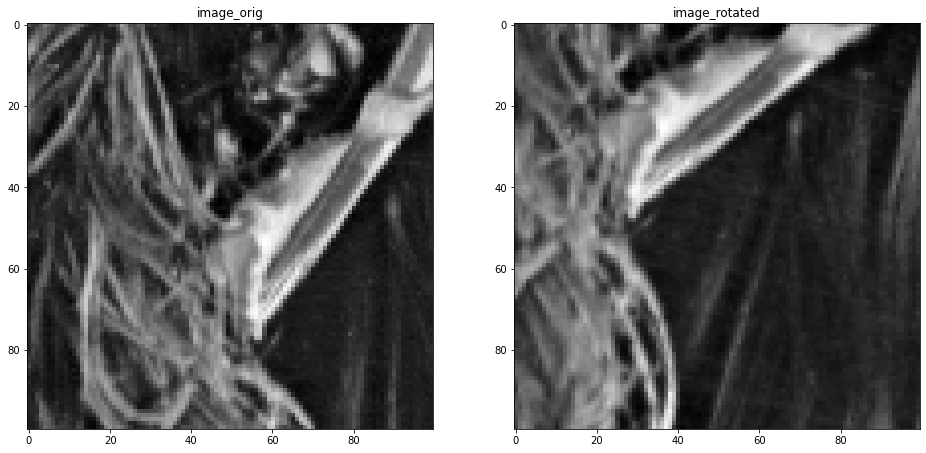

In [5]:
image_grey = cv2.imread('../data/Lena.png', cv2.IMREAD_GRAYSCALE)
image_rotd = cv2.imread('../data/Lena_rotated.png', cv2.IMREAD_GRAYSCALE)



######################################
print_image('data/Lena.png','image_grey',image_grey,300,305,100,127)
print_image('image_rotd','image_rotd',image_rotd,300,305,100,127)
plt_view_image(plt,[["data/Lena.png", draw_grid(np.copy(image_grey),100,(255,255,255))],
                    ["data/Lena_rotated.png",
                     draw_grid(np.copy(image_rotd),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

plt_view_image(plt,[["image_orig", image_grey[300:400,100:200]],
                    ["image_rotated", image_rotd[300:400,100:200]]],
               figsize=(16,8), axis='on', cmap='gray')

In [6]:
detectorORB = cv2.ORB_create(100)


################################################
# Print all default params
print( "MaxFeatures: {}".format(detectorORB.getMaxFeatures()) )
print( "Threshold: {}".format(detectorORB.getFastThreshold()) )
print( "Pyramid decimation ratio, greater than 1:{}".format(detectorORB.getScaleFactor()) )
print( "The number of pyramid levels:{}".format(detectorORB.getNLevels()) )
print( "algorithm string identifier: {}".format(detectorORB.getDefaultName()))

MaxFeatures: 100
Threshold: 20
Pyramid decimation ratio, greater than 1:1.2000000476837158
The number of pyramid levels:8
algorithm string identifier: Feature2D.ORB


------  fea0---------------------    Shape(100, 32) fea0: uint8
[ 60 37 ]
[ 48 54 ]
[ 1 163 ]
[ 169 100 ]
[ 236 112 ]
[ 49 217 ]
Total Keypoints with nonmaxSuppression: 100 
kps.shape  == (100, 2)
<KeyPoint 0000019A62E86BA0>
------  cv2.KeyPoint_convert kps_orig    Shape(100, 2) kps_og: float32
[ 180.0 434.0 ]
[ 178.0 433.0 ]
[ 173.0 311.0 ]
[ 273.0 263.0 ]
[ 111.0 269.0 ]
[ 291.0 179.0 ]
31.0 177.2284393310547
31.0 173.40972900390625
31.0 231.9964599609375
31.0 53.98635482788086
31.0 295.07940673828125
31.0 3.3164281845092773


<ipython-input-7-e6ec32ae3d22>:30: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)


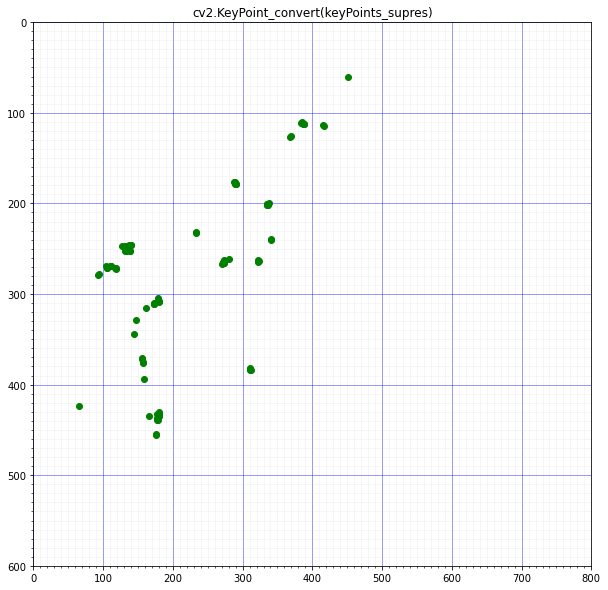

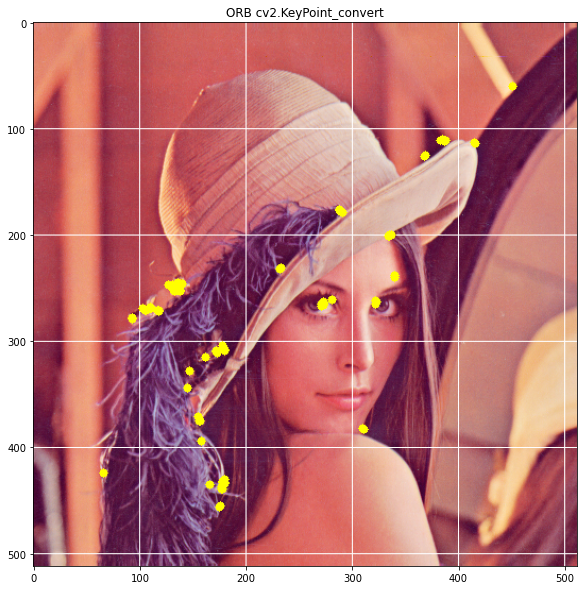

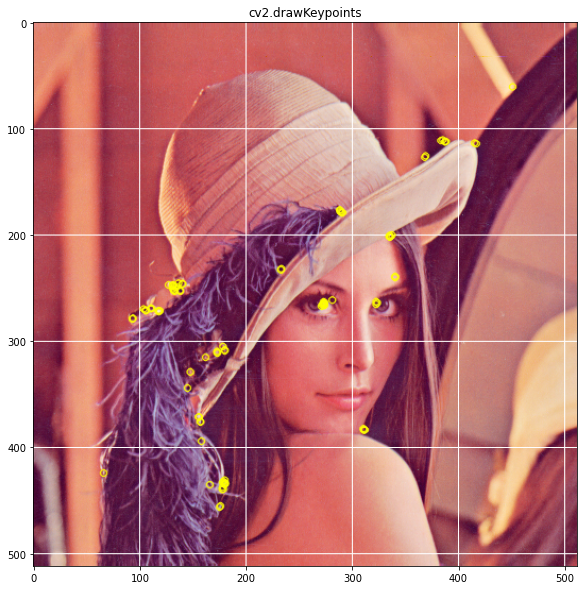

In [7]:
kps_orig, fea0 = detectorORB.detectAndCompute(image_grey, None)



#####################################################
print_image('fea0','fea0',fea0,0,6,0,2)
print( "Total Keypoints with nonmaxSuppression: {0} ".format(len(kps_orig)) )
print('kps.shape  ==',cv2.KeyPoint_convert(kps_orig).shape )
print(kps_orig[0])



#cv2.KeyPoint([x, y, _size[, _angle[, _response[, _octave[, _class_id]]]]]) → <KeyPoint object
# x – x-coordinate of the keypoint
# y – y-coordinate of the keypoint
# _pt – x & y coordinates of the keypoint
# _size – keypoint diameter
# _angle – keypoint orientation
# _response – keypoint detector response on the keypoint (that is, strength of the keypoint)
# _octave – pyramid octave in which the keypoint has been detected
# _class_id – object id

kps_og = cv2.KeyPoint_convert(kps_orig)
print_image('cv2.KeyPoint_convert kps_orig','kps_og',kps_og,0,6,0,2)
for kp in kps_orig[:6]: print(kp.size, kp.angle)
    
    
image_ORB = draw_grid(np.copy(image_orig),100,(255,255,255))
for p in cv2.KeyPoint_convert(kps_orig):
    cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)

image_Keypoints_orig = cv2.drawKeypoints(draw_grid(np.copy(image_orig),100,(255,255,255)), 
                                        kps_orig, None, (0,255, 255))

##############################
plt.figure(figsize=(10,10))
plt_view_grid(plt, 'on',(0,800,0,600),(100,10,100,10),major_color='b')
plt.title('cv2.KeyPoint_convert(keyPoints_supres)')
plt.plot(kps_og[:,0],kps_og[:,1],'o', color="green")
plt.gca().invert_yaxis()
plt.show()

plt_view_image(plt,[["ORB cv2.KeyPoint_convert",image_ORB[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_Keypoints_orig[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')

------  fea1---------------------    Shape(100, 32) fea1: uint8
[ 49 39 ]
[ 236 10 ]
[ 9 163 ]
[ 167 181 ]
[ 216 195 ]
[ 49 221 ]
Total Keypoints with nonmaxSuppression: 100 
kps.shape  == (100, 2)
<KeyPoint 0000019A60C55450>
------  cv2.KeyPoint_convert kps_rotd    Shape(100, 2) kps_rotd: float32
[ 129.0 346.0 ]
[ 132.0 412.0 ]
[ 161.0 288.0 ]
[ 147.0 216.0 ]
[ 136.0 410.0 ]
[ 310.0 190.0 ]
31.0 225.48989868164062
31.0 227.51101684570312
31.0 251.61318969726562
31.0 257.2813720703125
31.0 205.86474609375
31.0 15.182088851928711


<ipython-input-8-4cb77da843b4>:19: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_Rotated, tuple(p), 4, (0, 255, 255), cv2.FILLED)


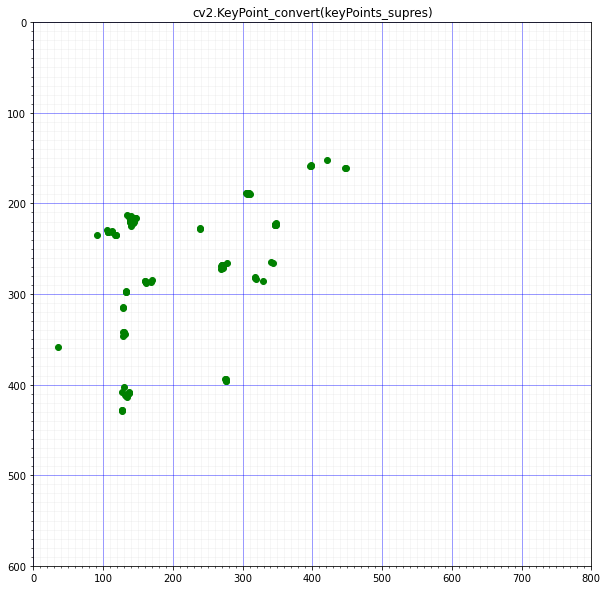

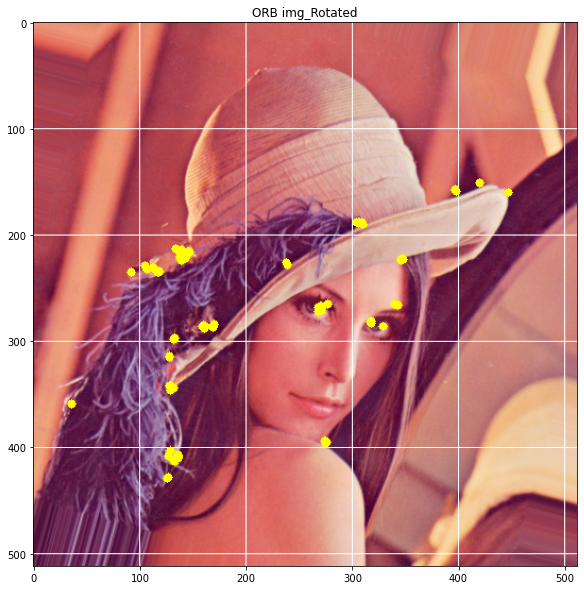

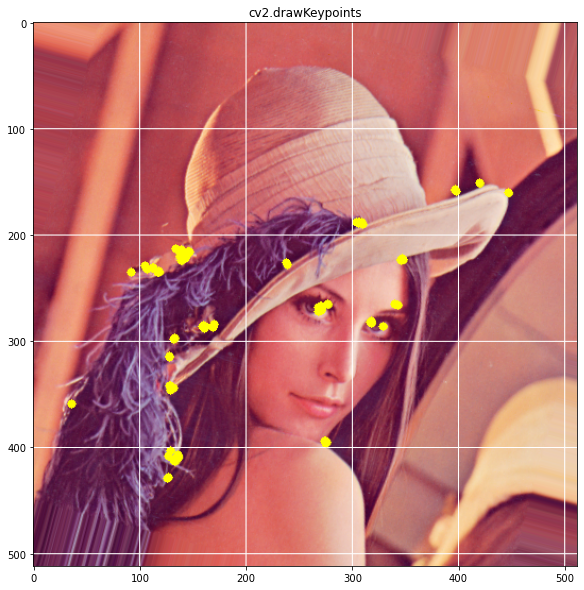

In [8]:
kps_rotated, fea1 = detectorORB.detectAndCompute(image_rotd, None)




#####################################################
print_image('fea1','fea1',fea1,0,6,0,2)
print( "Total Keypoints with nonmaxSuppression: {0} ".format(len(kps_rotated)) )
print('kps.shape  ==',cv2.KeyPoint_convert(kps_rotated).shape )
print(kps_rotated[0])

kps_rotd = cv2.KeyPoint_convert(kps_rotated)
print_image('cv2.KeyPoint_convert kps_rotd','kps_rotd',kps_rotd,0,6,0,2)
for kp in kps_rotated[:6]: print(kp.size, kp.angle)
    
    
img_Rotated = draw_grid(np.copy(image_rotated),100,(255,255,255))
for p in cv2.KeyPoint_convert(kps_rotated):
    cv2.circle(img_Rotated, tuple(p), 4, (0, 255, 255), cv2.FILLED)

image_Keypoints_rotd = cv2.drawKeypoints(draw_grid(np.copy(img_Rotated),100,(255,255,255)), 
                                        kps_rotated, None, (0,255, 255))

##############################
plt.figure(figsize=(10,10))
plt_view_grid(plt, 'on',(0,800,0,600),(100,10,100,10),major_color='b')
plt.title('cv2.KeyPoint_convert(keyPoints_supres)')
plt.plot(kps_rotd[:,0],kps_rotd[:,1],'o', color="green")
plt.gca().invert_yaxis()
plt.show()

plt_view_image(plt,[["ORB img_Rotated",img_Rotated[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_Keypoints_rotd[:,:,[2,1,0]]]],
               figsize=(10,10), axis='on', cmap='gray')

In [9]:
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, False)
matches01 = matcher.knnMatch(fea0, fea1, k=2)
matches10 = matcher.knnMatch(fea1, fea0, k=2)

In [10]:
def ratio_test(matches, ratio_thr):
    good_matches = []
    for m in matches:
        ratio = m[0].distance / m[1].distance
        if ratio < ratio_thr:
            good_matches.append(m[0])
    return good_matches

RATIO_THR = 0.7  # Lower values mean more aggressive filtering.
good_matches01 = ratio_test(matches01, RATIO_THR)
good_matches10 = ratio_test(matches10, RATIO_THR)

In [11]:
good_matches10_ = {(m.trainIdx, m.queryIdx) for m in good_matches10}
final_matches = [m for m in good_matches01 if (m.queryIdx, m.trainIdx) in good_matches10_]

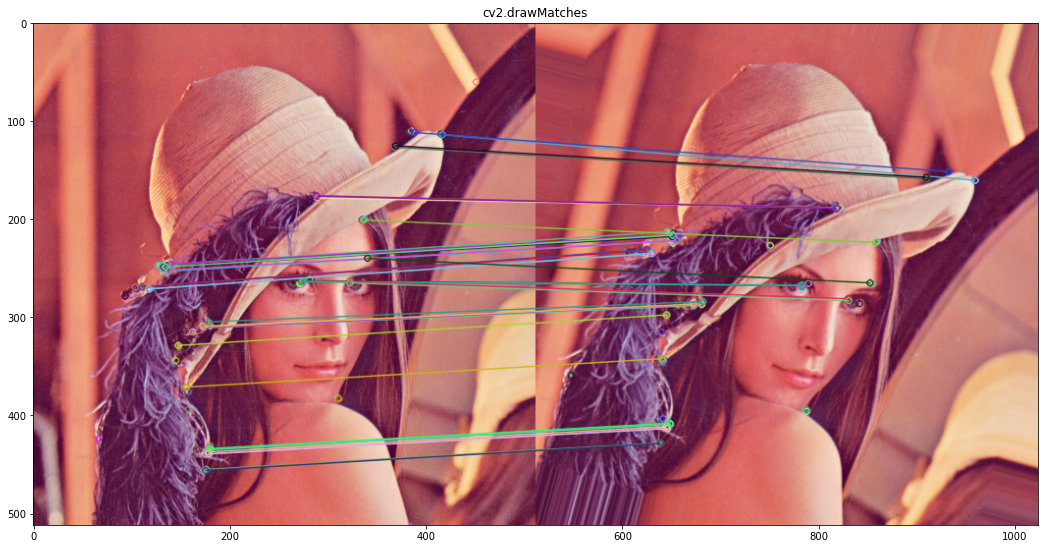

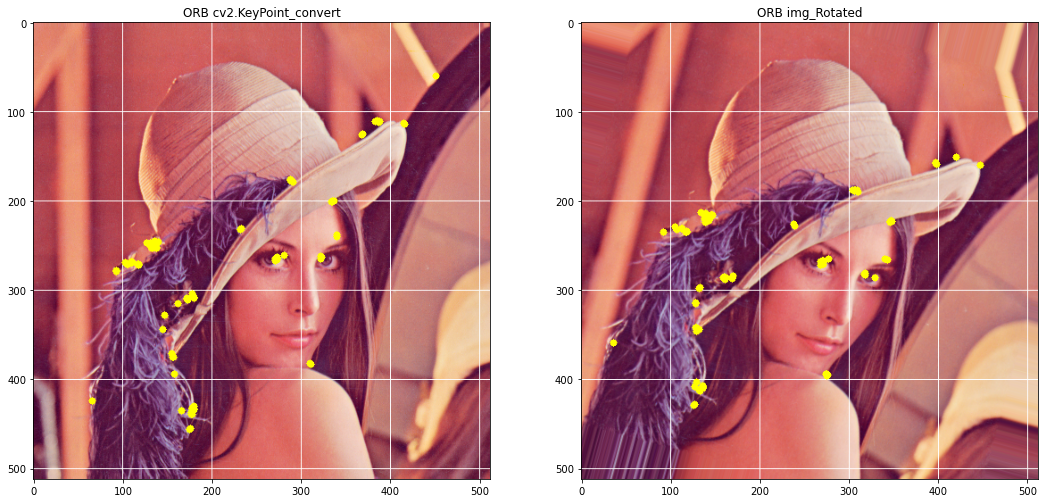

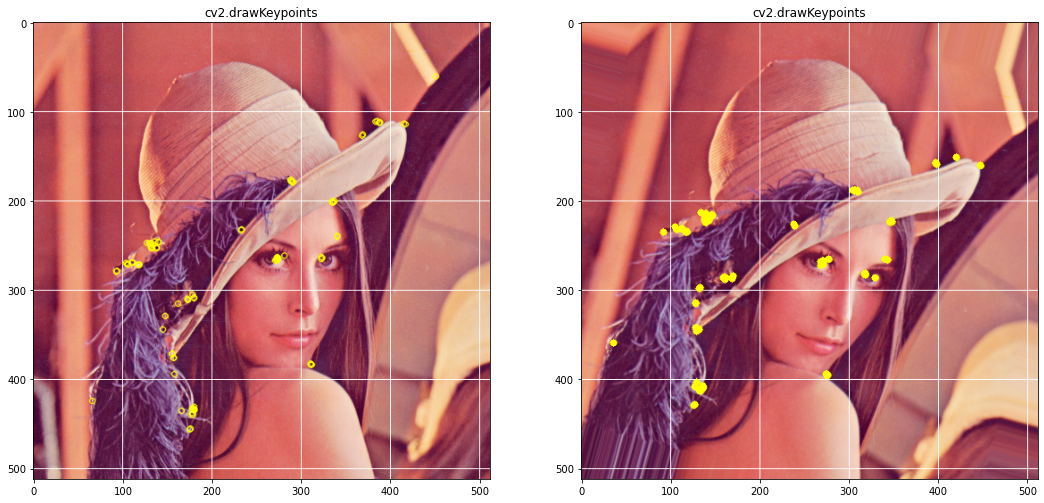

In [12]:
dbg_img = cv2.drawMatches(image_orig, kps_orig, image_rotated, kps_rotated, final_matches, None)




############################################################################
plt_view_image(plt,[["cv2.drawMatches",dbg_img[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')

plt_view_image(plt,[["ORB cv2.KeyPoint_convert",image_ORB[:,:,[2,1,0]]],
                    ["ORB img_Rotated",img_Rotated[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_Keypoints_orig[:,:,[2,1,0]]],
                    ["cv2.drawKeypoints", image_Keypoints_rotd[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')